In [1]:
import pennylane as qml

In [2]:
################ Code from the 'Optimization of molecular geometries' tutorial##################
# imports and relevant defines:
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import time

# Simulation starting parameters:
symbols = ["O", "H", "H"]

# this is selected from the tutorial 'Building molecular Hamiltonians', which has the same nulcear-coordinats for water
x = np.array([0.028,  0.054,  0.10,
              0.986,  1.610, -0.10,
              1.855,  0.002,  0.20], requires_grad=True)
# these parameters are used to match up with the parameters for the VQE run on water in the paper: https://arxiv.org/pdf/2106.13840.pdf
active_electrons = 8
active_orbitals = 6

# define the hamiltonian needed to compute cost-function
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons,
                                           active_orbitals = active_orbitals, method = "pyscf")[0]

#hf = qml.qchem.hf_state(electrons=active_electrons, orbitals=active_orbitals)
#print(hf)

In [3]:
# Need to run this: functions to allow us to calculate angle between OH1 and OH2:
import math

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return (np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/math.pi) #convert to degrees

In [ ]:
# * OPTIONAL* run this if you want to plot 3d:

%matplotlib widget
import numpy as np_orig
import matplotlib.pyplot as plt
def plot_3d(x):
    X = [x[0], x[3], x[6]]
    Y = [x[1], x[4], x[7]]
    Z = [x[2], x[5], x[8]]
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    labels = ['O', 'H1', 'H2']
    plt.title("Water Molecule")
    
    ax.text(x[0], x[1], x[2], 'O', color='red')
    ax.text(x[3], x[4], x[5], 'H1', color='red')
    ax.text(x[6], x[7], x[8], 'H2', color='red')
    
    ax.scatter3D(X,Y,Z)
    ax.set_xlabel('x-axis')
    ax.set_ylabel('y-axis')
    ax.set_zlabel('z-axis')

In [4]:
################ Code from the 'Building the adaptive circuit' tutorial below:################
active_electrons = active_electrons
active_orbitals = active_orbitals

H, qubits = qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons, active_orbitals = active_orbitals)
singles, doubles = qchem.excitations(active_electrons, qubits)

hf_state = qchem.hf_state(active_electrons, qubits)
print(hf_state)



#compute the significant double-excitation gates:
def circuit_1(params, excitations):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)
    return qml.expval(H)

dev = qml.device("default.qubit", wires=qubits)
cost_fn = qml.QNode(circuit_1, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(doubles)
grads = circuit_gradient(params, excitations=doubles)
print("Computed gradients for all possible Double Excitation Gates: \n")
for i in range(len(doubles)):
    print(f"Excitation : {doubles[i]}, Gradient: {grads[i]}")   
doubles_select = [doubles[i] for i in range(len(doubles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected double-excitation gates: ", len(doubles_select))



# optimizing the parameters for the double-excitation gates for Ansatz-wavefunction construction
opt = qml.GradientDescentOptimizer(stepsize=0.5)
params_doubles = np.zeros(len(doubles_select), requires_grad=True)
for n in range(20):
    params_doubles = opt.step(cost_fn, params_doubles, excitations=doubles_select)
print("Done!")



#compute the significant single-excitation gates:
def circuit_2(params, excitations, gates_select, params_select):
    qml.BasisState(hf_state, wires=range(qubits))

    for i, gate in enumerate(gates_select):
        if len(gate) == 4:
            qml.DoubleExcitation(params_select[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params_select[i], wires=gate)

    for i, gate in enumerate(excitations):
        if len(gate) == 4:
            qml.DoubleExcitation(params[i], wires=gate)
        elif len(gate) == 2:
            qml.SingleExcitation(params[i], wires=gate)
    return qml.expval(H)


cost_fn = qml.QNode(circuit_2, dev, interface="autograd")
circuit_gradient = qml.grad(cost_fn, argnum=0)
params = [0.0] * len(singles)
grads = circuit_gradient(
    params,
    excitations=singles,
    gates_select=doubles_select,
    params_select=params_doubles
)
print("Computed gradients for all possible Single Excitation Gates: \n")
for i in range(len(singles)):
    print(f"Excitation : {singles[i]}, Gradient: {grads[i]}")
singles_select = [singles[i] for i in range(len(singles)) if abs(grads[i]) > 1.0e-5]
print("")
print("Number of selected single-excitation gates: ", len(singles_select))

#Total Number of Gates selected to construct the Quantum Ansatz:
print("Total selected gates: "+  str(len(doubles_select) + len(singles_select)))

################# End code from the 'Building the adaptive circuit' tutorial ##################

[1 1 1 1 1 1 1 1 0 0 0 0]
Computed gradients for all possible Double Excitation Gates: 

Excitation : [0, 1, 8, 9], Gradient: -0.11187677542286904
Excitation : [0, 1, 8, 11], Gradient: 0.0013870700134139841
Excitation : [0, 1, 9, 10], Gradient: -0.0013870700134139841
Excitation : [0, 1, 10, 11], Gradient: -0.05621303503578509
Excitation : [0, 2, 8, 10], Gradient: 0.00014525888670513428
Excitation : [0, 3, 8, 9], Gradient: 0.04473596626384695
Excitation : [0, 3, 8, 11], Gradient: -0.001602481885371587
Excitation : [0, 3, 9, 10], Gradient: 0.0014572229986664577
Excitation : [0, 3, 10, 11], Gradient: 0.004084385212820825
Excitation : [0, 4, 8, 10], Gradient: -0.03480327512070869
Excitation : [0, 5, 8, 9], Gradient: 0.0028449205331799424
Excitation : [0, 5, 8, 11], Gradient: 0.06775622491894245
Excitation : [0, 5, 9, 10], Gradient: -0.03295294979823377
Excitation : [0, 5, 10, 11], Gradient: -0.0025009348098806797
Excitation : [0, 6, 8, 10], Gradient: 0.0
Excitation : [0, 7, 8, 9], Gradient

In [5]:
################ Resume from the 'Optimization of molecular geometries' tutorial below: ################
hf = hf_state


#Construct optimized parametrized circuit that will be used to run the optimized VQE algorithm
# using the selected single and double excitation gates:
num_wires = qubits
dev = qml.device("lightning.qubit", wires=num_wires)
@qml.qnode(dev, interface="autograd")
def circuit(params, obs, wires):
    # prepares reference state
    qml.BasisState(hf, wires=wires)
    
    # apply all single excitations
    for i, singles in enumerate(singles_select):
        qml.SingleExcitation(params[i], wires=singles)
        
    # apply all double excitations
    for j, doubles in enumerate(doubles_select):
        qml.DoubleExcitation(params[j + len(singles_select)], wires=doubles)
                             
    # returns expectation value of the ansatz prepared from this quantum circuit:   
    return qml.expval(obs)

def cost(params, x):
    hamiltonian = H(x)
    return circuit(params, obs=hamiltonian, wires=range(num_wires)) 
    

# This function computes the finite-difference of the Hamiltonian itself with respect to each of the nuclear-coordinates
# itself, using a central-difference approximation.
def finite_diff(f, x, delta=0.01):
    """Compute the central-difference finite difference of a function"""
    gradient = []
    for i in range(len(x)):
        shift = np.zeros_like(x)
        shift[i] += 0.5 * delta
        res = (f(x + shift) - f(x - shift)) * delta**-1 # dH/dx            
        gradient.append(res)

    return gradient

def grad_x(params, x): #evaluate the expectation of the gradient components (each of the nuclear components of the Hamiltonian)
    grad_h = finite_diff(H, x)
    grad = [circuit(params, obs=obs, wires=range(num_wires)) for obs in grad_h]
    return np.array(grad)

In [25]:
# Run this block every-time you want to re-run/re-initialize algorithms in prep for running
# the algorith,in the block below this one:

# initialize optimizers:
opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)


# Re-initialize all relevant parameters to be optimized:
# nuclear-coordinate parameters:
symbols = ["O", "H", "H"]
x = np.array([0.028,  0.054,  0.10,
              0.986,  1.610, -0.10,
              1.855,  0.002,  0.20], requires_grad=True)

# circuit parameters:
theta = np.array([0.0] * (len(doubles_select) + len(singles_select)), requires_grad=True)

print("Reinitialized gradient descent parameters!")


# re-define the hamiltonian needed to compute cost-function (otherwise it gives error: Hamiltonian function not callable
# when I run the actual gradient descent code below)
def H(x):
    return qml.qchem.molecular_hamiltonian(symbols, x, charge=0, active_electrons = active_electrons,
                                           active_orbitals = active_orbitals, method = "pyscf")[0]



Reinitialized gradient descent parameters!


In [26]:
from functools import partial

# store the values of the cost function
energy = []

# store the values of the bond length
bond_length = []
bond_angle = []

# Factor to convert from Bohrs to Angstroms
bohr_angs = 0.529177210903

for n in range(200):
    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    
    # recalculate bond length and append:
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)
    
    # recalculate bond angle and append:
    OH1 = x[0:3] - x[3:6]
    OH2 = x[0:3] - x[6:9]
    bond_angle.append(angle_between(OH1, OH2))
    

    if n % 1 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha")
        print(f"Bond length = {bond_length[-1]:.5f} A, Bond angle = {bond_angle[-1]:.5f}" + '\u00b0')

    maximum_grad = np.max(grad_x(theta, x))
    print("Maximum Gradient = ", maximum_grad)
    print("")
    # Check maximum component of the nuclear gradient
    if maximum_grad <= 1e-05:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

Step = 0,  E = -74.95126850 Ha
Bond length = 1.01172 A, Bond angle = 67.91479°
Maximum Gradient =  3.799033226132944

Step = 1,  E = -72.57188063 Ha
Bond length = 6.69976 A, Bond angle = 56.88694°
Maximum Gradient =  0.01378645185420145

Step = 2,  E = -72.58856838 Ha
Bond length = 6.68741 A, Bond angle = 57.01226°
Maximum Gradient =  0.03312509436482314

Step = 3,  E = -72.61133605 Ha
Bond length = 6.69498 A, Bond angle = 57.95434°
Maximum Gradient =  0.06929869991095673

Step = 4,  E = -72.62870586 Ha
Bond length = 6.39200 A, Bond angle = 58.48944°
Maximum Gradient =  126.67985648528872

Step = 5,  E = -72.33873804 Ha
Bond length = 46.51649 A, Bond angle = 5.51330°
Maximum Gradient =  0.0063816226565222775

Step = 6,  E = -72.39384872 Ha
Bond length = 46.51453 A, Bond angle = 5.51930°
Maximum Gradient =  0.0060267246479546715

Step = 7,  E = -72.48454043 Ha
Bond length = 46.51273 A, Bond angle = 5.52478°
Maximum Gradient =  0.0054986532964871535

Step = 8,  E = -72.62148869 Ha
Bond l

KeyboardInterrupt: 

In [ ]:
bond_length[-1], bond_angle[-1]

In [ ]:
# This block is same as above block. Only difference is that it doesn't have array initializations, but initializes the 
# optimizers at different step sizes.
# Run this notebook if you want to pause kernel and don't want to reset arrays storing bond_length, bond_angle, and energy.
# Also, if you notice gradient-descent isn't converging, then we can run this to initialize the gradient-descent
# objects to step at * smaller * values.

opt_theta = qml.GradientDescentOptimizer(stepsize=0.4)
opt_x = qml.GradientDescentOptimizer(stepsize=0.8)
for n in range(n, 200):

    # Optimize the circuit parameters
    theta.requires_grad = True
    x.requires_grad = False
    theta, _ = opt_theta.step(cost, theta, x)

    # Optimize the nuclear coordinates
    x.requires_grad = True
    theta.requires_grad = False
    _, x = opt_x.step(cost, theta, x, grad_fn=grad_x)

    energy.append(cost(theta, x))
    
    # recalculate bond length and append:
    bond_length.append(np.linalg.norm(x[0:3] - x[3:6]) * bohr_angs)
    
    # recalculate bond angle and append:
    OH1 = x[0:3] - x[3:6]
    OH2 = x[0:3] - x[6:9]
    bond_angle.append(angle_between(OH1, OH2))
    

    if n % 1 == 0:
        print(f"Step = {n},  E = {energy[-1]:.8f} Ha")
        print(f"Bond length = {bond_length[-1]:.5f} A, Bond angle = {bond_angle[-1]:.5f}" + '\u00b0')

    maximum_grad = np.max(grad_x(theta, x))
    print("Maximum Gradient = ", maximum_grad)
    print("")
    # Check maximum component of the nuclear gradient
    if maximum_grad <= 1e-05:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" "Ground-state equilibrium geometry")
print("%s %4s %8s %8s" % ("symbol", "x", "y", "z"))
for i, atom in enumerate(symbols):
    print(f"  {atom}    {x[3 * i]:.4f}   {x[3 * i + 1]:.4f}   {x[3 * i + 2]:.4f}")

In [ ]:
################# OPTIONAL: Plotting and Visualization #################

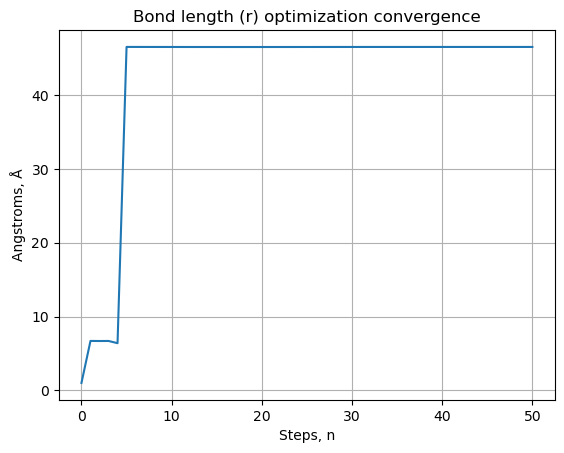

In [27]:
# Run this to plot 2D stuff:
import matplotlib.pyplot as plt
np_bl = np.array(bond_length)
np_ba = np.array(bond_angle)
plt.figure(1)
plt.plot(np_bl)
plt.xlabel("Steps, n")
plt.ylabel("Angstroms, Å")
plt.title("Bond length (r) optimization convergence")
plt.grid(True)

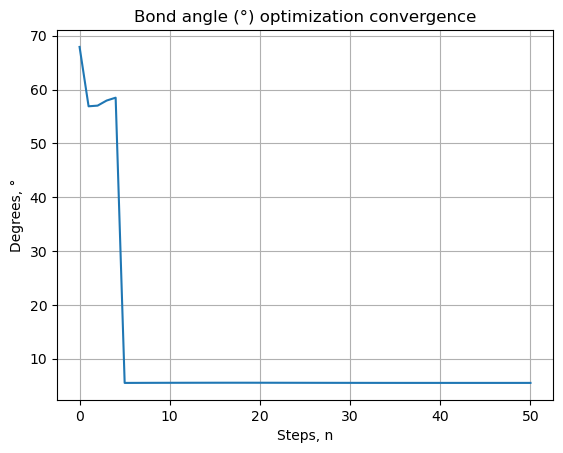

In [28]:
plt.figure(2)
plt.plot(np_ba)
plt.xlabel("Steps, n")
plt.ylabel("Degrees, \u00b0")
plt.title("Bond angle (\u00b0) optimization convergence")
plt.grid(True)

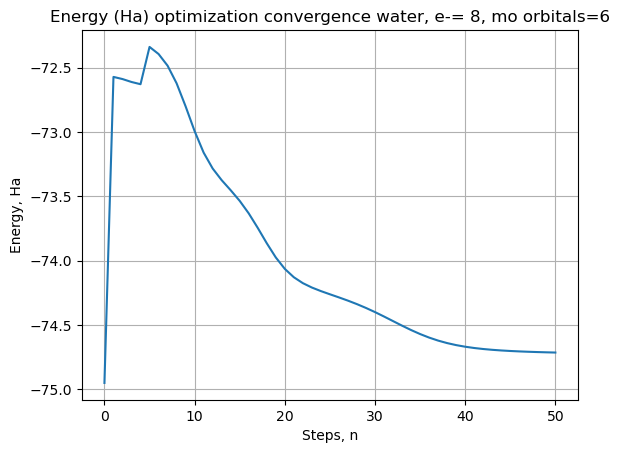

In [29]:
plt.figure(3)
plt.plot(energy)
plt.xlabel("Steps, n")
plt.ylabel("Energy, Ha")
plt.title("Energy (Ha) optimization convergence water, e-= 8, mo orbitals=6")
plt.grid(True)

In [ ]:
# OPTIONAL: Run this to plot 3D stuff, assuming function block at beginning was run

# plot the initial-coordinates I used
original_x = x
plot_3d(original_x)

In [ ]:
# plot the coordinates Soran provided:
rotated_x = np.array([0.028,  0.054,  0.10, 0.986,  1.610, -0.10, 1.855,  0.002,  0.20])
plot_3d(rotated_x)

In [ ]:
# ~~ End Notebook ~~